In [1]:
import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import illustrisFuncs as iF
from scipy.optimize import curve_fit
from numpy.linalg import inv

plt.style.use('fancy_plots2.mplstyle')

# step 1: save position of all subhalos at every snapshot

In [6]:
def save_subhalo_pos(basePath):
    #load all trees
    sub_flag = il.groupcat.loadSubhalos(basePath,99,fields=['SubhaloFlag'])
    numSubs = sub_flag.shape[0]
    ids = np.arange(numSubs)
    trees = loadMPBs(basePath, 99, ids = ids, fields = ['SubhaloPos'])
    
    #find missing trees
    missing = []
    tree_check = list(trees)
    counter = 0
    for i in range(numSubs):
        if i != tree_check[counter]:
            missing.append(i)
            i+=1
            continue
        counter+=1
    
    #make all trees the same length
    SubhaloPos_allSubs = np.full((numSubs, 100, 3), np.nan)
    
    for i in range(numSubs):        
        if i in missing: #if subhalo hast no tree, skip it and create dataset filled with NaN
            sub_flag[i] = 0
            continue    
        length = trees[i]['count']
        SubhaloPos_allSubs[i,:length,:] = trees[i]['SubhaloPos'][:,:]
    
    #save trees
    f = h5py.File('files/' + basePath[32:39] + '/SubhaloPos_new.hdf5','w')
    f.create_dataset('SubhaloPos', data = SubhaloPos_allSubs)
    f.create_dataset('SubhaloFlag', data = sub_flag)
    f.close()
    return

In [10]:
%%time
sim = 'TNG50-1'
basePath='/virgotng/universe/IllustrisTNG/' + sim + '/output'
save_subhalo_pos(basePath)

CPU times: user 2min 2s, sys: 16.4 s, total: 2min 19s
Wall time: 3min 17s


wow, that's more than 3000 times faster than the old code...

# step 2: extrapolate strange positions of all subhalos

In [61]:
@jit(nopython = True)
def linear(x,a,b):
    return a*x+b

# @jit(nopython = True)
def normal_condition(coord,k, bad_values, cut, boxSize):
    if k == coord.size-1 or k == coord.size: #if last value is reached, then all values before must have been nice
        return True, False
    if k <= 10:
        mean_inds = np.delete(np.arange(k),bad_values[np.where(bad_values[1:] < k)])
        dist_to_mean = np.abs(coord[k]-np.mean(coord[mean_inds]))
        close_to_bound = np.abs(boxSize - dist_to_mean) < cut/2
        
        #check, whether coordinate differs more than cut
        cond = np.isfinite(coord[k]) and dist_to_mean <= cut
#         print('condition: ',cond)
        if not cond: #when condition is not fulfilled:
            #if coordinate differs too much: try next time step -> one error is okay
            dist_to_mean = np.abs(coord[k+1] - np.mean(coord[mean_inds]))
            cond = np.isfinite(coord[k+1]) and dist_to_mean <= cut
            bad = True #but value before is labeled as 'bad'
            return cond, bad
        bad = False
    else: #if more than 10 steps already: only consider the last 10 steps (=snaps)
        mean_inds = np.delete(np.arange(k-10, k),\
                              bad_values[np.where(np.logical_and(bad_values[1:] < k,bad_values[1:] > k-10))])
        if k == 80:
            print(bad_values[-5:])
            print(bad_values[np.where(np.logical_and(bad_values[1:] < k,bad_values[1:] > k-10))])
            print(mean_inds)
        dist_to_mean = np.abs(coord[k] - np.mean(coord[mean_inds]))
        cond =  np.isfinite(coord[k]) and dist_to_mean <= cut
        if k == 80:
            print(dist_to_mean, cond)
        if not cond:
            dist_to_mean = np.abs(coord[k+1]-np.mean(coord[mean_inds]))
             
            cond = np.isfinite(coord[k+1]) and dist_to_mean <= cut
            
            if k == 80:
                print('save? ',dist_to_mean, cond)
            
            bad = True
            return cond, bad
        bad = False
    return cond, bad

@jit(nopython = True)
def linear_fit(x,y):
    A = np.column_stack((np.ones(x.shape[0]), x))
    opt_param = np.ascontiguousarray(inv(A.T@A))@A.T@y
    return opt_param

@jit(nopython = True)
def extrapolate_new(arr, snaps, a, boxSize, cut, bound):
    is_extrapolated = np.full(arr.shape[0], False)
    test_counter = 0
    for i in nb.prange(arr.shape[0]): #extrapolate for every subhalo...
        for j in range(3): #... and every coordinate
         
            #if first or second coordinate could not be extrapolated:
#             print(is_extrapolated[i])
#             print(is_extrapolated_until_z6[i])
            if j > 0 and is_extrapolated[i] == False:
#                 print('skip')
                continue #skip the other ones
            coord = arr[i,:,j]
#             nonzero = np.nonzero(coord)[0]
            
            good_indices = np.arange(coord.size)
            gaps = np.where(np.isnan(coord))[0]
            
            if gaps.size > 80:
                is_extrapolated[i] = False
#                 print(i)
                continue
            
            top = np.where(coord > (1 - bound) * boxSize)[0]
            bottom = np.where(coord < bound * boxSize)[0]
            
            if top.size > 0 and bottom.size > 0:
                if top.size >= bottom.size:
                    gaps = np.concatenate((gaps, bottom))
                else:
                    gaps = np.concatenate((gaps, top))
            
#             print(gaps)
            good_indices = np.delete(good_indices, gaps)
            
            if i == 1000:
                print(good_indices)
            
            gap_coord = np.interp(a[gaps],a[good_indices],coord[good_indices])
            coord[gaps] = gap_coord
            new_coord = coord
            
            k = max(good_indices)
            if k < 100:
                #only extrapolate with four or more (good nonzero-) entries
                if(good_indices.size > 5): 
                    popt = linear_fit(a[good_indices[-5:]],coord[good_indices[-5:]])
                    if i== 1000:
                        print(a[good_indices[-5:]], coord[good_indices[-5:]])
#                     if np.abs(popt[1]) < 200:
                    new_coord[k:] = linear(a[k:],popt[1], popt[0])
                    if i==1000 or i==167392:
                        print('extrapolated snaps: ',snaps[k:])
                        
            
            new_coord[np.where(new_coord > boxSize)] -= boxSize
            new_coord[np.where(new_coord < 0)] += boxSize
            is_extrapolated[i] = True
#             bad_values = np.array([0]) #save values differing from the mean (to not using them for fitting)
            
#             k=1 #find the maximum coordiante that doesn't differ from the mean by more than cut
#             cond, bad_value = normal_condition(coord,k, bad_values, cut, boxSize)
#             while cond and k<=99:
#                 if bad_value:
#                     bad_values = np.append(bad_values,int(k))
#                 k+=1
#                 cond, bad_value = normal_condition(coord,k, bad_values, cut, boxSize)
                
#             bad_values = np.delete(bad_values,0) #delete leading 0 again

# #             print('sub, coordinate: ',i,j)
# #             print('bad values: ',bad_values)
# #             print('max good: ',k)
            
#             if k >= 99 and bad_values.shape[0] == 0: #if there are no bad values
#                 is_extrapolated[i] = True
#                 is_extrapolated_until_z6[i] = True
# #                 print('nice')
#                 continue #with next coordinate
            
#             fit_indices = np.arange(k)
#             fit_indices = np.delete(fit_indices,bad_values)
# #             if bad_values.size>1:
# #             if i == 167392:
# #                 print(bad_values)
#             print('sub, coordinate: ',i,j)
#             print('bad values: ',bad_values)
#             print('good indices: ',fit_indices)
            
#             #extrapolate single entries in between:
#             for bad_ind in range(bad_values.shape[0]):
#                 index = bad_values[bad_ind]
#                 before = fit_indices[:index]
#                 after = fit_indices[index + 1:]
#                 if before.shape[0] >= 5 or after.shape[0] >= 5:
#                     indices_for_fitting = np.concatenate((fit_indices[index - 5:index],\
#                                                         fit_indices[index + 1:index + 5]))
#                     popt = linear_fit(snaps[indices_for_fitting],coord[indices_for_fitting])
#                     if np.abs(popt[1]) > 200:
#                         test_counter += 1
#                         continue #with next bad value
#                     coord[index] = linear(snaps[index], popt[1], popt[0])
#                     if bad_values.shape[0] > 1:
#                         bad_values[bad_ind] = -1
#                     else:
#                         bad_values = np.array([-1])
# #                     print('single value extrapolated')

#             if (bad_values<0).all() and k >= 99:
#                 is_extrapolated[i] = True
#                 is_extrapolated_until_z6[i] = True
#             elif (bad_values<0).all() and k >= 87:
#                 is_extrapolated_until_z6[i] = True
#                 is_extrapolated[i] = False #can be saved below
#             else:
#                 is_extrapolated_until_z6[i] = False
#                 is_extrapolated[i] = False
# #                 print('bad values after extrapolation: ',bad_values)
#                 if not (bad_values<0).all():
#                     continue #with next coordinate
            
            #extrapolate the last entries
#             k = max(good_indices)
#             if k < 100:
#                 #only extrapolate with four or more (good nonzero-) entries
#                 if(good_indices.size > 5): 
#                     popt = linear_fit(a[good_indices[-5:]],coord[good_indices[-5:]])
#                     if np.abs(popt[1]) > 200:
#                         #print(i,end=' ')
#                         test_counter+=1
#                     else:
#                         coord[k:] = linear(snaps[k:],popt[1], popt[0])
#                         if (bad_values<0).all():
#                             is_extrapolated[i] = True
#                             is_extrapolated_until_z6[i] = True
#                         elif min(bad_values[np.where(bad_values > 0)]) > 87:
#                             is_extrapolated_until_z6[i] = True
#                             is_extrapolated[i] = False #can be saved below
# #                             print('bad values after extrapolation: ',bad_values)
            
#             #correct for boundary crossing
#             coord[np.where(coord > boxSize)] -= boxSize
#             coord[np.where(coord < 0)] += boxSize
            arr[i,:,j] = new_coord
            del coord
#     print(test_counter)
    return arr, is_extrapolated

In [58]:
gaps = np.array([0,5,9])
x = np.arange(20,40)
y = x * 2
print(np.interp(x[gaps],x,y))

[40. 50. 58.]


In [87]:
print(a)

[1.         0.99056814 0.97658689 0.96737586 0.95372195 0.94472658
 0.93139235 0.92260759 0.90958556 0.90100647 0.88828933 0.87575168
 0.86749171 0.8552476  0.84718103 0.8352236  0.82343493 0.81566841
 0.80415576 0.7928056  0.78532797 0.77058363 0.76331559 0.75254187
 0.74192021 0.73492252 0.72454954 0.71432298 0.70424076 0.69430084
 0.68450121 0.6748399  0.66531496 0.65592445 0.64666649 0.63452548
 0.62556955 0.61674002 0.60803512 0.59661941 0.5881985  0.57715521
 0.56900902 0.55832602 0.55044559 0.54011111 0.52997065 0.52002058
 0.51268081 0.50067736 0.49127726 0.48205365 0.47300321 0.46412269
 0.45325613 0.44474636 0.43433346 0.42416436 0.41423335 0.40071934
 0.39506344 0.38398999 0.37499959 0.36448853 0.35427208 0.344342
 0.33310814 0.32224077 0.31172794 0.30155808 0.29034102 0.2795412
 0.26787083 0.25668768 0.24949284 0.2334794  0.22267443 0.21236949
 0.1996827  0.19316822 0.18422877 0.17653754 0.1667797  0.16057599
 0.15314485 0.1460576  0.14263794 0.13348287 0.12491542 0.1214140

In [62]:
#extrapolate positions
def extrapolatePos(boxSize, a, cut, bound):
    f = h5py.File('files/'+ basePath[32:39] +'/SubhaloPos_new.hdf5', "r")
    snaps = np.arange(99,-1,-1)
    ids = np.array([0,1000,167392])
    indcs = np.array([79,80,93])
    indcs = np.arange(0,14)
    arr = f['SubhaloPos'][:,:,:]
    print(arr[1,indcs,1])
    
    #extrapolate positions and save
    res, is_extrapolated = extrapolate_new(arr,snaps,a,boxSize, cut, bound) 
    print(res[1,indcs,1])
    print(np.where(is_extrapolated == False)[0].size)
#     print(is_extrapolated)
#     print(is_extrapolated_until_z6)
#     extrapolate_new.parallel_diagnostics(level=4)
    result = h5py.File('files/'+ basePath[32:39] +'/SubhaloPos_new_extrapolated.hdf5', 'w')
    result.create_dataset('SubhaloPos',data = res)
    result.create_dataset('is_extrapolated', data = is_extrapolated)
    f.close()
    result.close()
    return

In [63]:
%%time
sim = 'TNG50-1'
basePath='/virgotng/universe/IllustrisTNG/' + sim + '/output'
boxSize = il.groupcat.loadHeader(basePath,99)['BoxSize']
z = iF.give_z_array(basePath)
a = 1/(1+z)
cut = 500
bound = 0.1
extrapolatePos(boxSize, a, cut, bound)

[24897.57226562 24942.84960938 25001.83203125 25035.46484375
 25078.89453125 25103.29492188 25133.08007812 25148.29296875
 25164.         25169.69921875 25170.72070312 25161.57617188
 25149.37304688 25120.37695312]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
[0.11634526 0.11096103 0.10582597 0.09997661 0.09625777] [2310.98803711 2290.27954102 2262.02661133 2215.62109375 2188.79174805]
extrapolated snaps:  [5 4 3 2 1 0]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
[0.11634526 0.11096103 0.10582597 0.09997

In [90]:
f = h5py.File('files/' + basePath[32:39] + '/SubhaloPosAtAllSnaps_extrapolated.hdf5','r')
g = h5py.File('files/' + basePath[32:39] + '/SubhaloPos_new_extrapolated.hdf5','r')
is_extrapolated = g['is_extrapolated'][:]
print(np.where(is_extrapolated == False)[0].shape[0])
sub_id = 1000#167392#167392#632099#454171
sub_pos_old = f['SubhaloPos'][sub_id,:,:]
sub_pos_new = g['SubhaloPos'][sub_id,:,:]

print(is_extrapolated[sub_id])

reference = il.sublink.loadTree(basePath, 99, id = sub_id, fields = ['SubhaloPos'], onlyMPB = True)

f.close()
g.close()

883071
True


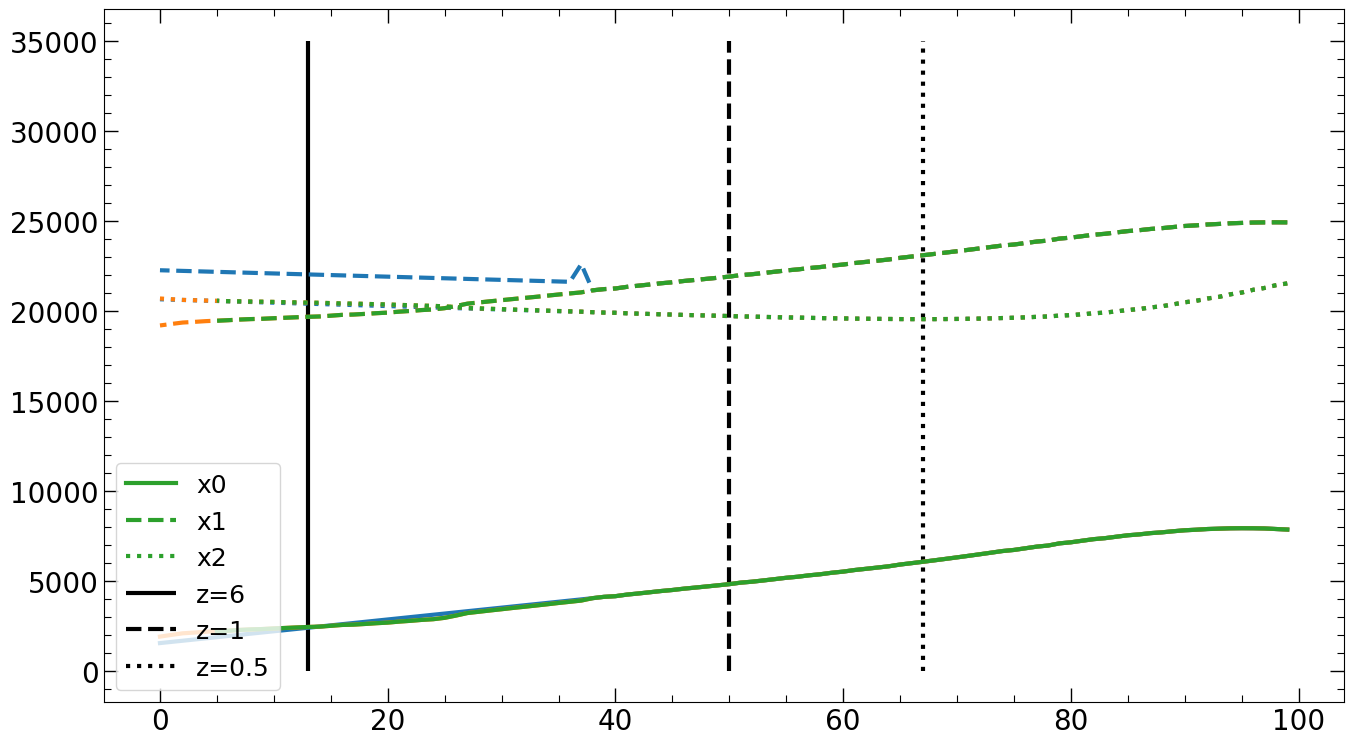

In [91]:
snaps = np.arange(99,-1,-1)
plt.plot(snaps, sub_pos_old[:,0], color = 'tab:blue', linestyle = 'solid')
plt.plot(snaps, sub_pos_old[:,1], color = 'tab:blue', linestyle = 'dashed')
plt.plot(snaps, sub_pos_old[:,2], color = 'tab:blue', linestyle = 'dotted')

plt.plot(snaps, sub_pos_new[:,0], color = 'tab:orange', linestyle = 'solid')
plt.plot(snaps, sub_pos_new[:,1], color = 'tab:orange', linestyle = 'dashed')
plt.plot(snaps, sub_pos_new[:,2], color = 'tab:orange', linestyle = 'dotted')

count = reference.shape[0]
plt.plot(snaps[:count], reference[:,0], color = 'tab:green', linestyle = 'solid', label = 'x0')
plt.plot(snaps[:count], reference[:,1], color = 'tab:green', linestyle = 'dashed', label = 'x1')
plt.plot(snaps[:count], reference[:,2], color = 'tab:green', linestyle = 'dotted', label = 'x2')

plt.vlines(13, 0, 35000, color = 'black', label = 'z=6')
plt.vlines(50, 0, 35000, color = 'black', linestyle = 'dashed', label = 'z=1')
plt.vlines(67, 0, 35000, color = 'black', linestyle = 'dotted', label = 'z=0.5')
plt.legend(loc = 'lower left')
#plt.savefig('pics/tmp.pdf', format = 'pdf')

In [80]:
coo = 1
print(reference[:,coo] - sub_pos_new[:count,coo])
print(sub_pos_new[:count,coo])
print(sub_pos_new[:,coo] - sub_pos_old[:,coo])

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.0801802]
[7335.54345703 7342.8671875  7353.06445312 7360.23095703 7371.10253906
 7378.72216797 7389.94384766 7397.4140625  7408.8046875  7416.37646484
 7427.57958984 7438.87402344 7446.33300781 7457.69873047 7465.22070312
 7477.10498047 7488.76220703 7497.31054688 7508.86425781 7521.12304688
 7529.05273438 7545.48974609 7553.62011719 7565.95996094 7578.33886719
 7586.90087891 7599.44238281 7611.40039062 7624.58691406 7636.84179688
 7649.55908203 7660.95458984 7673.11083984 7685.60888672 7697.85791016
 7713.73242188 7726.31494141 7738.20605469 7750.75195312 7767.30908203
 7779.80419922 7